In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import re
import os
import pickle


from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

import tensorflow as tf
import tensorflow.keras as keras 
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
# from tensorflow.keras import utils
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, Flatten, Embedding, Concatenate, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential

from keras.utils.vis_utils import plot_model
from sklearn.metrics import  f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import nltk
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
%load_ext tensorboard
import datetime
 # Clear any logs from previous runs
!rm -rf ./logs/
# %tensorboard --logdir logs/fit




## Load Data and Preprocess

In [ ]:
!gdown --id "1IKPfj6pBPe5wjx1GjRquxyLJ8VKdtebN"

Downloading...
From: https://drive.google.com/uc?id=1IKPfj6pBPe5wjx1GjRquxyLJ8VKdtebN
To: /content/documents.rar
19.0MB [00:00, 116MB/s] 


In [ ]:
!mkdir data
!unrar e documents.rar "data"

In [ ]:
import chardet
rawdata = open("data/alt.atheism_49960.txt", 'rb').read()
print(chardet.detect(rawdata))
print("ENCODING: ",chardet.detect(rawdata)["encoding"])

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}
ENCODING:  ISO-8859-1


In [ ]:
text_list = []
class_label_list = []
for fileName in os.listdir("data"):
  class_label  = "".join(fileName.split("_")[:-1])
  class_label_list.append(class_label)
  with open("data/"+ fileName,"r",encoding="ISO-8859-1") as textFile:
    text_list.append(textFile.read())

In [ ]:
data = pd.DataFrame(data={"text" : text_list, "class"  : class_label_list})


In [ ]:
def getEmail(text):
  re_email = re.compile("([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+)")
  emails = re.findall(re_email, text)
  email_list = []
  for email in emails:
    for word in email.split("@")[-1].split("."):
      if len(word) >= 2 and word != "com":
        email_list.append(word)

  email_removed = re.sub(re_email," ",text)
  return email_removed, " ".join(email_list)

In [ ]:
def getSubject(text):
  re_subject = re.compile("^Subject: .*$",re.MULTILINE)
  sub = re.findall(re_subject,text)[0]
  sub_list = []

  for word in sub.split(":")[1:]:
    # only keeps alphabets and numbers
    word = re.sub('[^A-Za-z0-9\s]+', '', word)
    # remove \n \r 
    # r'' indicates to treat string as raw string and ignore meaning on \n and \r
    word = re.sub(r'[\n\r\t]', '', word)
    sub_list.append(word)

  remove_subject = re.sub(re_subject, " ", text)
  return remove_subject, " ".join(sub_list)


In [ ]:
def removeLines(text):
  re_from = re.compile("^From: .*$",re.MULTILINE)
  re_write = re.compile("^Write To: .*$",re.MULTILINE)

  
  removed_text = re.sub(re_from, "", text) # From:
  removed_text = re.sub(re_write, "", removed_text) # Write To:
  removed_text = re.sub("<.*>", "", removed_text) # < word >
  removed_text = re.sub("\(.*\)", "", removed_text) # ( word )
  removed_text = re.sub(r'[\n\r\t-/]', " ", removed_text) # remove \n \r
  removed_text = re.sub('\s+',' ',removed_text) # replace multiple spaces with one space
  removed_text = re.sub('\w*:', '', removed_text) # remove words ending with : ex- text:
  removed_text = re.sub('[^\w\s]','',removed_text)
  
  return removed_text

In [ ]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    

    return phrase


In [ ]:
def initial_preprocess_data(data):
  email_list = []
  subject_list = []
  processed_text_list = []

  text ,email = getEmail(data)
  email_list = email

  text, subject = getSubject(text)
  subject_list= subject

  text = removeLines(text)
  text = decontracted(text)

  return (text, email_list, subject_list)

In [ ]:
def chunking(text):
  parse_tree = nltk.ne_chunk(nltk.tag.pos_tag(text.split()))
  leaf_list = []

  for t in parse_tree.subtrees():
    leaf_list = list(t) 
    break


  final_str = ""
  for x in leaf_list:
    if type(x) == Tree:
      if x.label() == 'PERSON': # ignore if Tree is PERSON
        continue
      final_str += "_".join([val for val,label in x.leaves()]) 
    else:
      final_str += x[0]
    final_str += " "

  return final_str.strip()


In [ ]:
def process_after_chunking(data):
  data = re.sub('[0-9]+'," ",data) #remove all digits
  data = re.sub('\b_\S+_\b|\b_\S+\b|\b\S+_\b'," ",data) #remove words like _abc, abc_, _abc_

  #remove one letter words : eg=>d_berlin
  clean_str = ""
  for word in data.split(" "):
    if len(word.split("_")) == 1:
      clean_str += word+" "
      continue

    temp_str = [w for w in word.split("_") if len(w)>2]
    clean_str += "_".join(temp_str)+" "
  
  clean_str = clean_str.strip()

  # convert all words into lower case
  # remove len(word)>=15 and len(word)<=2
  res_str = ""
  for word in clean_str.split(" "):
    word = word.lower()
    if len(word)>=15 or len(word)<=2:
      word = ""
    res_str += word+" "
  
  res_str = res_str.strip()
  
  # replace all the words except "A-Za-z_" with space
  clean_sentence = ""
  for word in res_str.split(" "):
    match_list = re.findall("^[A-Za-z_]+$",word)
    if len(match_list) == 0:
      continue
    else:
      clean_sentence += word + " "

  clean_sentence = clean_sentence.strip()

  return clean_sentence
    

In [ ]:
def preprocess(input_text):
    """Do all the Preprocessing as shown above and
    return a tuple contain preprocess_email,preprocess_subject,preprocess_text for that Text_data"""
    text, processed_email_list, processed_subject_list = initial_preprocess_data(input_text)
    text = chunking(text)
    clean_input_text = process_after_chunking(text)


    return (processed_email_list,processed_subject_list,clean_input_text)

## Test for file : alt.atheism_49960

In [ ]:
fileName = "alt.atheism_49960.txt"
with open("data/"+ fileName,"r",encoding="ISO-8859-1") as textFile:
    text = textFile.read()
    test_mail, test_sub, test_text = preprocess(text)
    print("EMAIL: ", test_mail)
    print("SUBJECT: ", test_sub)
    print("TEXT: ", test_text)

EMAIL:  mantis co uk netcom mantis co uk
SUBJECT:   AltAtheism FAQ  Atheist Resources
TEXT:  archive atheism resources alt atheism archive resources last december usa freedom from religion foundation darwin fish bumper stickers and assorted other atheist paraphernalia are available from the the write ffrf box madison evolution designs evolution designs sell the darwin fish fish symbol like the ones christians stick their cars but with feet and the word written inside the deluxe moulded plastic fish postpaid the write evolution designs north hollywood people the area can get from try mailing for net people who directly the price per fish american atheist press aap publish various atheist books critiques the bible lists biblical contradictions and one such book the bible_handbook and foote press isbn edition bible contradictions absurdities atrocities immoralities contains ball the aap based the king version the press box prometheus books_sell books including write east amherst street yo

## Build New dataframe from cleaned data

In [ ]:
text_list = []
email_list = []
subject_list = []

for row in tqdm(data["text"].values):
  email, sub, txt = preprocess(row)
  text_list.append(txt)
  email_list.append(email)
  subject_list.append(sub)

100%|██████████| 18828/18828 [20:58<00:00, 14.96it/s]


In [ ]:
df = pd.DataFrame({"text":data["text"].values, "class":data["class"].values, "preprocessed_text" : text_list, "preprocessed_email":email_list,"preprocessed_subject":subject_list})

# Model 1 : Word Encoding

## Load Data and Tokenize

In [ ]:
print(df.columns)
# concat into one column for training
df["train_text"] = df["preprocessed_text"] + df["preprocessed_email"]+ df["preprocessed_subject"]

X = df["train_text"].values
y = df["class"].values

oneEncoder = OneHotEncoder().fit(y.reshape(-1,1))
y = oneEncoder.transform(y.reshape(-1,1)).toarray()
# le.inverse_transform()

X_train, X_test, y_train, y_test = train_test_split(X,y ,test_size=0.25, random_state = 0, stratify=y)

print("X Train : (%dx%d) "%( len(X_train), len(X_train[0])))
print("Y Train : (%dx%d) "%( len(y_train), len(y_train[0])))

Index(['text', 'class', 'preprocessed_text', 'preprocessed_email',
       'preprocessed_subject'],
      dtype='object')
X Train : (14121x867) 
Y Train : (14121x20) 


In [ ]:
# df["train_text"]

In [ ]:
#use tf.tokenizer : remove '_' from filters as we need words joined by _ (new_york)
tokenizer = Tokenizer(lower=True, split=' ',filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(X_train)

# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)


In [ ]:
vocab_size = len(tokenizer.word_index) + 1
print("Learned Vocab has size : ",vocab_size)
maxlen = max([len(x) for x in train_sequences])
print("Maximum len of words in train_data is: ", maxlen)

Learned Vocab has size :  104876
Maximum len of words in train_data is:  8791


In [ ]:
# Pad the sequences based on maxLen
train_padded = pad_sequences(train_sequences, padding='post', truncating='post', maxlen=maxlen)
test_padded = pad_sequences(test_sequences, padding='post', truncating='post', maxlen=maxlen)

## Create Embedding Matrix

In [ ]:
#load GLove vector
!gdown --id "1MRsz-18c7i0nOMwYRG-CBbE65FLh58EM"

Downloading...
From: https://drive.google.com/uc?id=1MRsz-18c7i0nOMwYRG-CBbE65FLh58EM
To: /content/glove_vectors
128MB [00:01, 104MB/s] 


In [ ]:
with open('glove_vectors', 'rb') as f:
  glove_vector = pickle.load(f)
  glove_words = set(glove_vector.keys())

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
	embedding_vector = glove_vector.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [ ]:
print("Shape of Embedding Matrix: %d x %d"%(len(embedding_matrix),len(embedding_matrix[0])))

Shape of Embedding Matrix: 104876 x 300


## Build -> Model 1 


In [ ]:
class Metrics_Callback(tf.keras.callbacks.Callback):
  def __init__(self,x_val,y_val):
    self.x_val = x_val
    self.y_val = y_val

  def on_train_begin(self, logs={}):
    self.history = {"micro_f1":[]}

  def on_epoch_end(self, epoch, logs={}):
    # self.model.predict_classes
    y_pred = self.model.predict(self.x_val)

    y_true_labels = [np.argmax(x) for x in self.y_val]
    y_pred_labels = [np.argmax(x) for x in y_pred]
    micro_f1_s = f1_score(y_true_labels,y_pred_labels, average='micro')
    self.history["micro_f1"].append(micro_f1_s)


In [ ]:
input = Input(shape = (maxlen))
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False,name="Embedding_Layer")(input)

ba = Conv1D(filters=4, kernel_size=9, activation= 'relu')(embedding_layer)
bb = Conv1D(filters=8, kernel_size=9, activation= 'relu')(embedding_layer)
bc = Conv1D(filters=16, kernel_size=9, activation= 'relu')(embedding_layer)
concat1 = Concatenate(axis=2,name="Concat")([ba, bb, branch_c])

max_pool_1 = MaxPooling1D(pool_size=10,strides=1, padding='valid')(concat1)

branch_a_2 = Conv1D(filters=8, kernel_size=9, activation= 'relu')(max_pool_1)
branch_b_2 = Conv1D(filters=4, kernel_size=9, activation= 'relu')(max_pool_1)
branch_c_2 = Conv1D(filters=2, kernel_size=9, activation= 'relu')(max_pool_1)

concat2 = Concatenate()([branch_a_2, branch_b_2, branch_c_2])

max_pool_2 = MaxPooling1D(pool_size=10,strides=1, padding='valid')(concat2)

conv_filter = Conv1D(filters=32, kernel_size=9, activation= 'relu')(max_pool_2)

flatten = Flatten()(conv_filter)

drop = Dropout(0.4)(flatten)

dense1 = Dense(40,activation='relu',kernel_initializer=tf.keras.initializers.he_normal())

output = Dense(20, activation='softmax')(drop)

In [ ]:
model = keras.Model(input,output)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8791)]       0                                            
__________________________________________________________________________________________________
Embedding_Layer (Embedding)     (None, 8791, 300)    31462800    input_1[0][0]                    
__________________________________________________________________________________________________
Branch_A (Conv1D)               (None, 8783, 4)      10804       Embedding_Layer[0][0]            
__________________________________________________________________________________________________
Branch_B (Conv1D)               (None, 8783, 8)      21608       Embedding_Layer[0][0]            
______________________________________________________________________________________________

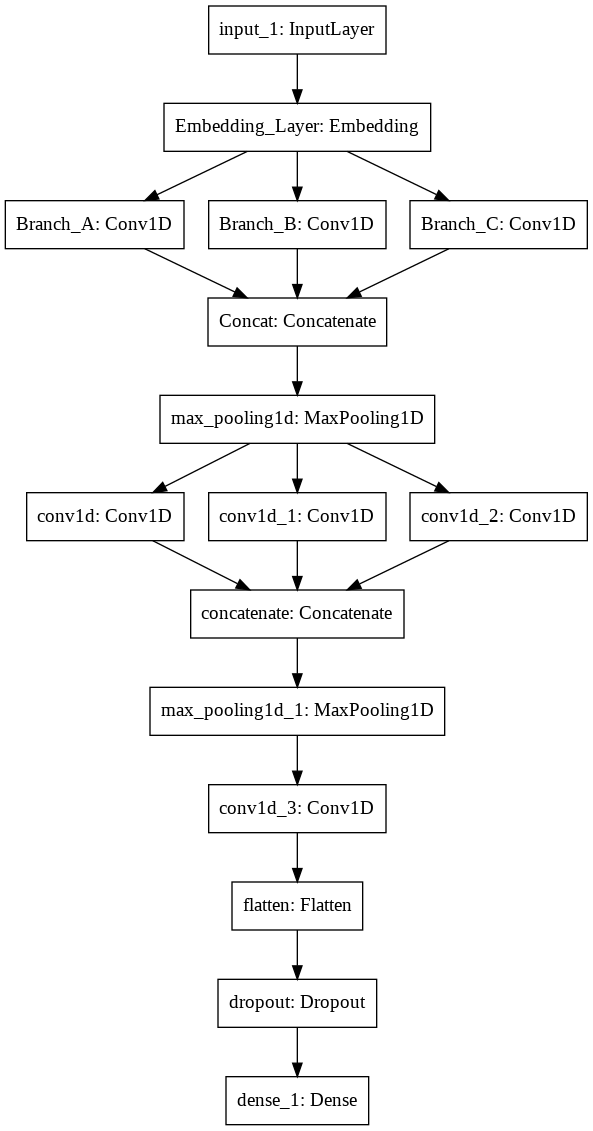

In [ ]:
plot_model(model)

In [ ]:
Metrics = Metrics_Callback(test_padded,y_test)

EarlyStop = EarlyStopping(monitor='accuracy',mode='max')

filePath = "best_model_1.h5"
model_checkpoint_callback = ModelCheckpoint(filepath=filePath,save_best_only=True,monitor='val_accuracy',mode='max')

!rm -rf logs/*
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True)


In [ ]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
model.fit(train_padded,y_train,
  epochs=10,
  validation_data=(test_padded,y_test),
  callbacks = [Metrics, EarlyStop, model_checkpoint_callback, tensorboard_callback])


Epoch 1/10
442/442 [==============================] - 126s 268ms/step - loss: 2.5556 - accuracy: 0.1871 - val_loss: 1.6482 - val_accuracy: 0.4483
Epoch 2/10
442/442 [==============================] - 118s 267ms/step - loss: 1.3164 - accuracy: 0.5447 - val_loss: 1.2525 - val_accuracy: 0.6125
Epoch 3/10
442/442 [==============================] - 118s 268ms/step - loss: 0.8579 - accuracy: 0.7005 - val_loss: 1.1925 - val_accuracy: 0.6584
Epoch 4/10
442/442 [==============================] - 118s 268ms/step - loss: 0.6004 - accuracy: 0.7891 - val_loss: 1.1475 - val_accuracy: 0.6877
Epoch 5/10
442/442 [==============================] - 119s 268ms/step - loss: 0.4760 - accuracy: 0.8310 - val_loss: 1.2408 - val_accuracy: 0.6909
Epoch 6/10
442/442 [==============================] - 118s 268ms/step - loss: 0.3767 - accuracy: 0.8720 - val_loss: 1.3851 - val_accuracy: 0.6913
Epoch 7/10
442/442 [==============================] - 118s 268ms/step - loss: 0.4587 - accuracy: 0.8521 - val_loss: 1.4809 -

In [ ]:
Metrics.history

{'micro_f1': [0.4482685362226471,
  0.6124920331421287,
  0.6583811344805609,
  0.6876991714467814,
  0.6908859145952836,
  0.6913108136817506,
  0.7142553643509666,
  0.7289143828340768,
  0.7270023369449755,
  0.7165923093265348]}

In [ ]:
# %tensorboard --logdir logs/fit


# Model 2 : Character Encoding

## Load Data and Tokenize

In [ ]:
print(df.columns)
# concat into one column for training
df["train_text"] = df["preprocessed_text"] + df["preprocessed_email"]+ df["preprocessed_subject"]

X = df["train_text"].values
y = df["class"].values

oneEncoder = OneHotEncoder().fit(y.reshape(-1,1))
y = oneEncoder.transform(y.reshape(-1,1)).toarray()
# le.inverse_transform()

X_train, X_test, y_train, y_test = train_test_split(X,y ,test_size=0.25, random_state = 0, stratify=y)

print("X Train : (%dx%d) "%( len(X_train), len(X_train[0])))
print("Y Train : (%dx%d) "%( len(y_train), len(y_train[0])))

Index(['text', 'class', 'preprocessed_text', 'preprocessed_email',
       'preprocessed_subject', 'train_text'],
      dtype='object')
X Train : (14121x867) 
Y Train : (14121x20) 


In [ ]:
tkn = Tokenizer(lower=True, char_level=True, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')

# update tkn.word_index
alphabet = "abcdefghijklmnopqrstuvwxyz_"
char_dict = {}
for i, char in enumerate(alphabet):
    char_dict[char] = i

# Use char_dict to replace the tk.word_index
tkn.word_index = char_dict.copy()

In [ ]:
# text to int sequence
train_sequences_char = tkn.texts_to_sequences(X_train)
test_sequences_char = tkn.texts_to_sequences(X_test)

max_len_char = max([len(x) for x in train_sequences_char])

# Pad the sequences based on maxLen
train_padded_char = pad_sequences(train_sequences_char, padding='post', truncating='post', maxlen=int(max_len_char/1.5))
test_padded_char = pad_sequences(test_sequences_char, padding='post', truncating='post', maxlen=int(max_len_char/1.5))

In [ ]:
len(train_padded_char[0])

31392

## Create Embedding Matrix

In [ ]:
#download char-embeddings glove
!wget https://raw.githubusercontent.com/minimaxir/char-embeddings/master/glove.840B.300d-char.txt

--2021-02-25 10:15:32--  https://raw.githubusercontent.com/minimaxir/char-embeddings/master/glove.840B.300d-char.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 265233 (259K) [text/plain]
Saving to: ‘glove.840B.300d-char.txt’

glove.840B.300d-cha 100%[===================>] 259.02K  --.-KB/s    in 0.03s   

2021-02-25 10:15:32 (7.76 MB/s) - ‘glove.840B.300d-char.txt’ saved [265233/265233]



In [ ]:
# Ref : https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python
def loadGloveModel(fileName):
    f = open(fileName,'r')
    gloveModel = {}
    for line in f:
        line_words = line.split(" ")
        word = line_words[0]
        wordEmbedding = np.array([float(value) for value in line_words[1:]])
        gloveModel[word] = wordEmbedding
    print(len(gloveModel)," words loaded!")
    return gloveModel

In [ ]:
char_glove = loadGloveModel("glove.840B.300d-char.txt")
print(len(char_glove["a"]))

94  words loaded!
300


In [ ]:
char_embedding_matrix = np.zeros((27, 300))
for word, i in tkn.word_index.items():
	embedding_vector = char_glove.get(word)
	if embedding_vector is not None:
		char_embedding_matrix[i] = embedding_vector

## Build -> Model 2


In [ ]:
print(max_len_char)
print(int(max_len_char/1.5))

47088
31392


In [ ]:
input = Input(shape = (int(max_len_char/1.5)))
embedding_layer = Embedding(27, 300, weights=[char_embedding_matrix], input_length=int(max_len_char/1.5), trainable=False)(input)

branch_a = Conv1D(filters=16, kernel_size=8, activation= 'relu')(embedding_layer)
branch_b = Conv1D(filters=16, kernel_size=12, activation= 'relu')(branch_a)
max_pool_1 = MaxPooling1D()(branch_b)

branch_a_2 = Conv1D(filters=16, kernel_size=12, activation= 'relu')(max_pool_1)
branch_b_2 = Conv1D(filters=16, kernel_size=12, activation= 'relu')(branch_a_2)
max_pool_2 = MaxPooling1D()(branch_b_2)

flatten = Flatten()(max_pool_2)
drop = Dropout(0.5)(flatten)
dense1 = Dense(128,activation='relu')(drop)
output = Dense(20, activation='softmax')(dense1)

In [ ]:
model2 = keras.Model(input,output)

In [ ]:
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 31392)]           0         
_________________________________________________________________
embedding (Embedding)        (None, 31392, 300)        8100      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 31385, 16)         38416     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 31374, 16)         3088      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 15687, 16)         0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 15676, 16)         3088      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 15665, 16)         3088

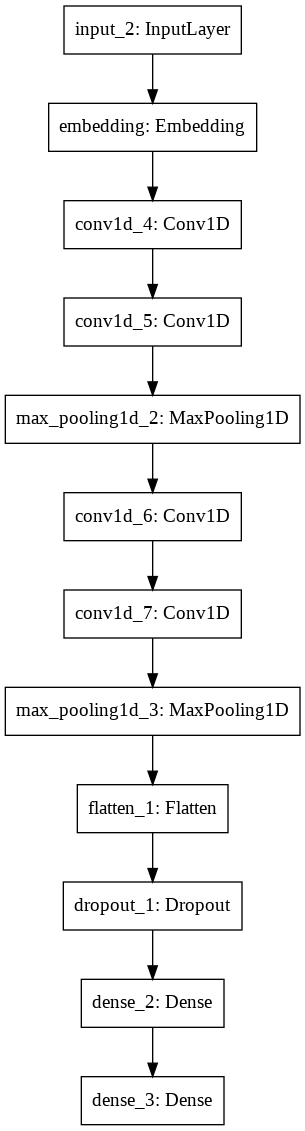

In [ ]:
plot_model(model2)

In [ ]:
Metrics = Metrics_Callback(test_padded_char,y_test)

# EarlyStop = EarlyStopping(monitor='accuracy',mode='max')

filePath = "best_model_2.h5"
model_checkpoint_callback = ModelCheckpoint(filepath=filePath,save_best_only=True,monitor='val_accuracy',mode='max')

!rm -rf logs/*
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True)


In [ ]:
model2.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
model2.fit(train_padded_char,y_train,
  epochs=10,
  validation_data=(test_padded_char,y_test),
  callbacks = [Metrics, model_checkpoint_callback, tensorboard_callback])


Epoch 1/10
442/442 [==============================] - 262s 589ms/step - loss: 3.0026 - accuracy: 0.0482 - val_loss: 2.9914 - val_accuracy: 0.0529
Epoch 2/10
442/442 [==============================] - 261s 590ms/step - loss: 2.9914 - accuracy: 0.0528 - val_loss: 2.9905 - val_accuracy: 0.0529
Epoch 3/10
442/442 [==============================] - 261s 590ms/step - loss: 2.9906 - accuracy: 0.0521 - val_loss: 2.9904 - val_accuracy: 0.0531
Epoch 4/10
442/442 [==============================] - 260s 589ms/step - loss: 2.9920 - accuracy: 0.0502 - val_loss: 2.9903 - val_accuracy: 0.0527
Epoch 5/10
442/442 [==============================] - 261s 590ms/step - loss: 2.9897 - accuracy: 0.0532 - val_loss: 2.9903 - val_accuracy: 0.0527
Epoch 6/10
442/442 [==============================] - 260s 589ms/step - loss: 2.9893 - accuracy: 0.0513 - val_loss: 2.9904 - val_accuracy: 0.0529
Epoch 7/10
442/442 [==============================] - 261s 590ms/step - loss: 2.9900 - accuracy: 0.0475 - val_loss: 2.9903 -

In [ ]:
Metrics.history

{'micro_f1': [0.052899936265137025,
  0.052899936265137025,
  0.053112385808370514,
  0.052687486721903556,
  0.052687486721903556,
  0.052899936265137025,
  0.052899936265137025,
  0.052687486721903556,
  0.052687486721903556,
  0.052899936265137025]}

In [ ]:
%tensorboard --logdir logs/fit
# 

In [ ]:
!jupyter nbconvert --to html "/content/Document_Classification.ipynb"

[NbConvertApp] Converting notebook /content/Document_Classification.ipynb to html
[NbConvertApp] Writing 973401 bytes to /content/Document_Classification.html
